<font style="font-size:40px">Example lesson</font>
<p><font style="font-size:26px">Bootstrapping for better sales reports</font></p>

---

1. [Introduction](#h1_introduction)
1. [Workspace setup](#h1_workspace_setup)
1. [Load data](#h1_load_data)
1. [Data exploration](#h1_data_exploration)
1. [Data cleaning](#h1_data_cleaning)
1. [Create a basic sales report](#h1_basic_sales_report)
1. [Create a better sales report](#h1_better_sales_report)

# Introduction
<a id='h1_introduction'></a>

In this session, we will create a basic sales report for a data set from an online retailer. We will then apply bootstrapping to identify which of the apparent trends are statistically significant.

> “Offered the choice between mastery of a five-foot shelf of analytical statistics books and middling ability at performing statistical Monte Carlo simulations, we would surely choose to have the latter skill.”
>
> _— Numerical Recipes: The Art of Scientific Computing_

## Learning goals
* Use pandas `groupby()`, `agg()` and `apply()` for dataframe aggregation.
* Use pandas `apply()` with a custom aggregate function.
* Understanding of how to modify template code to produce a bootstrapped sales report.

## Assumed prior knowledge
Python:
* __pandas__: Dataframe interrogation and slicing. Familiarity with `groupby()`, `agg()` and `apply()` beneficial but not necessary.
* __numpy__: `np.sum()`; `np.mean()`; `np.random.choice()`.

Other:
* Some familiarity with the concepts of bootstrapping and Monte Carlo methods. (Perhaps these were introduced in the previous session.)

# Workspace setup
<a id='h1_workspace_setup'></a>

In [5]:
# Run a few common commands.
%run workspace_setup.py

✔ workspace_setup.


## Imports

In [6]:
# Common.
import os
import numpy as np
import pandas as pd

# Charting.
import seaborn as sns

# Misc.
from IPython.display import Image # Display an image.

In [7]:
# `qa_fns` contains a few functions for producing charts and dataframes for this lesson.
import functions.qa_fns as qa

In [8]:
%aimport functions.qa_fns

# Load data
<a id='h1_load_data'></a>
`retail_df` is a pandas dataframe containing sales data for an online retailer.

The dataframe has been saved in the pickle format instead of the more common CSV. The main advantage of the pickle format is that it faithfully preserves the dataframe object, including column dtypes.

Data source: https://www.kaggle.com/mashlyn/online-retail-ii-uci.

In [9]:
retail_df = pd.read_pickle(os.path.join('..', 'data', 'retail.pkl'))
retail_df.shape

(53711, 4)

## Key

Column name | Description
--- | ---
Index: `invoice_id` | Unique order ID. Prefix "C" indicates a cancelled order.
`invoice_date_dt` | Datetime of order.
`period_id` | Year and quarter of order.
`country` | Country order placed from.
`order_value` | Order value in GBP.

# Data exploration
<a id='h1_data_exploration'></a>

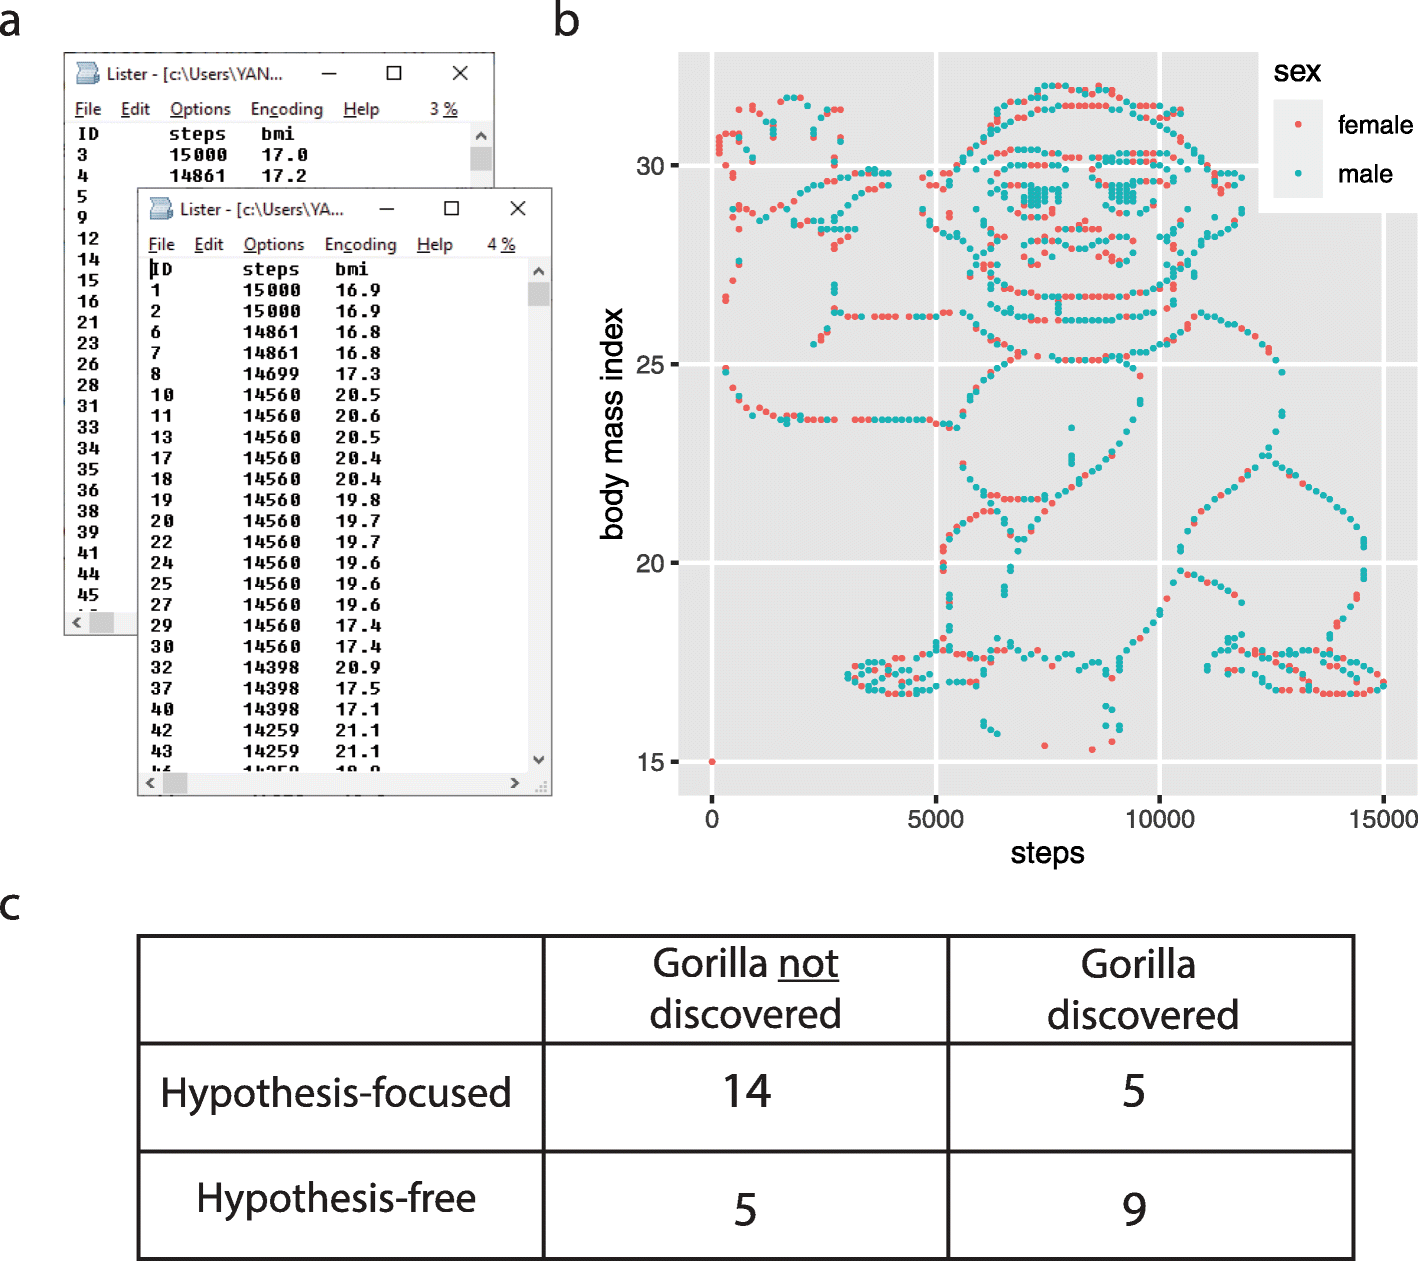

In [10]:
# A reminder of why data exploration is important.
Image(os.path.join('..', 'images', 'bmi_steps.png'), retina=True)

## Quick glance

Spend a few minutes examining the dataframe, `retail_df`, any way you like.

Some functions that might be useful:
* `pd.DataFrame.head(n)`
* `pd.DataFrame.sample(n)`
* `pd.DataFrame.describe()`
* `pd.DataFrame.dtypes()`
* `set()` or `pd.Series.unique()`
* `pd.Series.sum()`; `pd.Series.mean()`
* `pd.DataFrame.groupby(...).describe()`
* `pd.DataFrame.groupby(...).agg(...)`

Example: `retail_df.sample(10)`.

In [11]:
retail_df.head()

,invoice_date_dt,period_id,country,order_value
invoice_id,,,,
489434,2009-12-01 07:45:00,Q4_2009,United Kingdom,505.30
489435,2009-12-01 07:46:00,Q4_2009,United Kingdom,145.80
489436,2009-12-01 09:06:00,Q4_2009,United Kingdom,630.33
489437,2009-12-01 09:08:00,Q4_2009,United Kingdom,310.75
489438,2009-12-01 09:24:00,Q4_2009,United Kingdom,2286.24


In [12]:
retail_df.sample(5)

,invoice_date_dt,period_id,country,order_value
invoice_id,,,,
512175,2010-06-14 11:58:00,Q2_2010,United Kingdom,104.15
532438,2010-11-12 11:21:00,Q4_2010,United Kingdom,188.33
516308,2010-07-19 14:06:00,Q3_2010,Belgium,90.00
547336,2011-03-22 11:45:00,Q1_2011,United Kingdom,0.00
533777,2010-11-18 16:10:00,Q4_2010,United Kingdom,16.35


In [13]:
len(retail_df['country'].unique())

43

In [14]:
retail_df.describe()

,order_value
count,53711.000000
mean,359.093120
std,1652.062636
min,-168469.600000
25%,0.000000
50%,195.990000
75%,403.260000
max,168469.600000


In [15]:
retail_df.dtypes

invoice_date_dt    datetime64[ns]
period_id                category
country                    object
order_value               float64
dtype: object

In [16]:
retail_df['period_id'].dtype

CategoricalDtype(categories=['Q4_2009', 'Q1_2010', 'Q2_2010', 'Q3_2010', 'Q4_2010',
                  'Q1_2011', 'Q2_2011', 'Q3_2011', 'Q4_2011'],
, ordered=True)

Do any of the histograms look "unusual"?

## Aggregation
We will use the pandas dataframe methods `groupby()`, `agg()` and `sort_values()` to compute some aggregate statistics on `retail_df`.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html

An example of the syntax is given below.

In [21]:
n_invoices_by_country_df = retail_df.groupby([
    'country'
]).agg(
    n_invoices=('order_value', 'count') # Syntax: new_aggregate_column_name=('existing_column_name', 'builtin_function_name' or custom_function_name).
).sort_values(
    by='n_invoices',
    ascending=False
)

n_invoices_by_country_df.head(10)

,n_invoices
country,
United Kingdom,49183
Germany,1097
EIRE,808
France,747
Netherlands,250
Spain,188
Belgium,183
Sweden,129
Portugal,124


### Plot

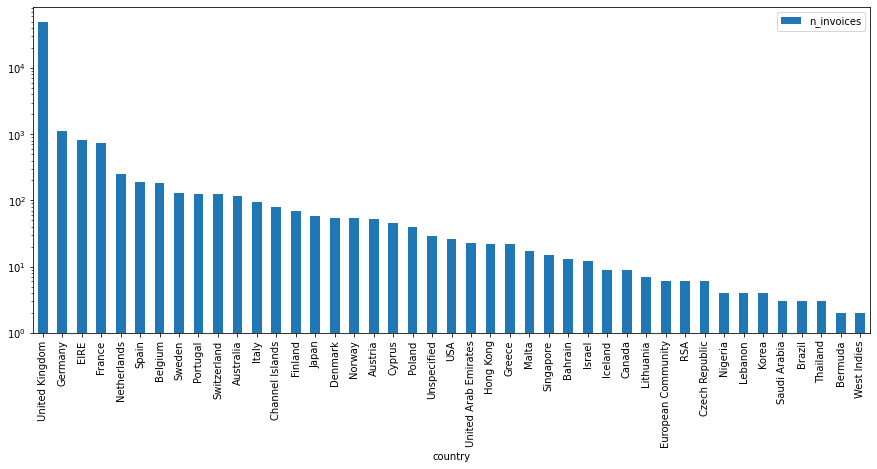

In [22]:
n_invoices_by_country_df.plot.bar(
    log=True,
    figsize=(15, 6)
);

## Exercise
Modify the code that generated `n_invoices_by_country_df` to create a new dataframe, `sales_by_country_df`. You will need to use the aggregate function "sum" instead of "count".

Call `plot.bar()` on this new dataframe, as we did above.

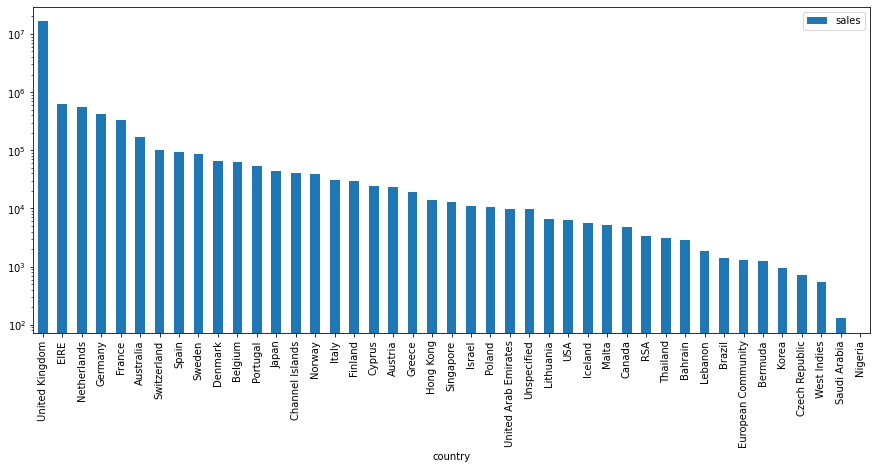

In [23]:
sales_by_country_df = retail_df.groupby([
    'country'
]).agg(
    sales=('order_value', 'sum'),
).sort_values(
    by='sales',
    ascending=False
)

sales_by_country_df.plot.bar(
    log=True,
    figsize=(15, 6)
);

## Exercise
The UK seems to have much higher sales than the other countries.

What fraction of all sales value comes from the UK?

In [24]:
sum(retail_df.loc[retail_df['country'] == 'United Kingdom', 'order_value']) / sum(retail_df['order_value'])

0.8493996507817793

## Filter `retail_df` to just the countries with highest sales
There are a lot of countries with very low sales. Let's focus on just the top 12 countries for the remainder of the session.

In [25]:
top_selling_countries = sales_by_country_df.index[:12]
top_selling_countries

Index(['United Kingdom', 'EIRE', 'Netherlands', 'Germany', 'France',
       'Australia', 'Switzerland', 'Spain', 'Sweden', 'Denmark', 'Belgium',
       'Portugal'],
      dtype='object', name='country')

In [26]:
len(retail_df)

53711

In [27]:
retail_df = retail_df.loc[retail_df['country'].isin(top_selling_countries)]

In [28]:
len(retail_df)

53002

## Histograms
We will plot a histogram of order value for each country.

There is a pandas built-in method, `hist()`, for plotting these histograms with a single command. However, the results are not always visually clear.

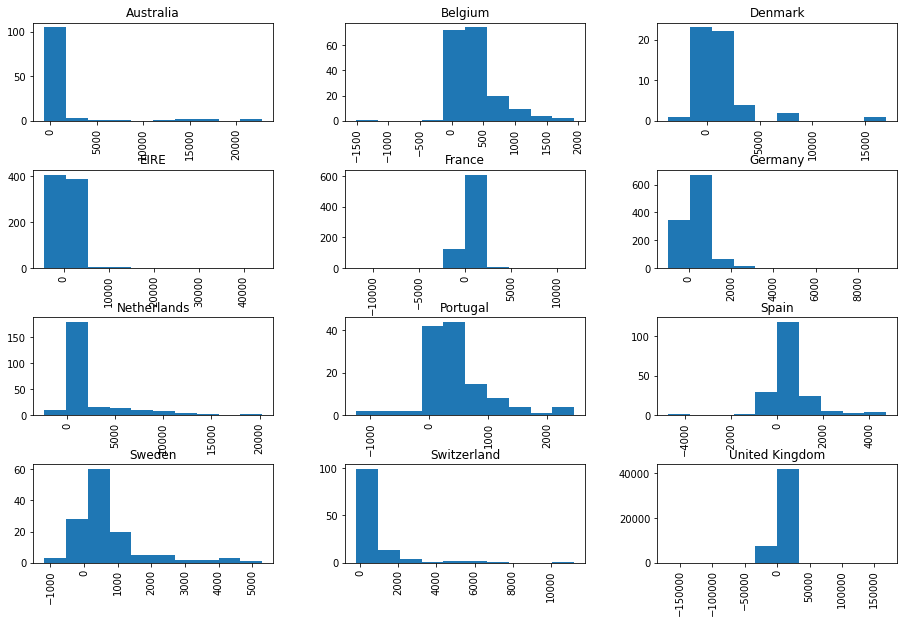

In [29]:
retail_df['order_value'].hist(
    by=retail_df['country'],
    figsize=(15, 10),
    #bins=40
);

We can generate better-looking histograms by employing seaborn.

A wrapper function, `seaborn_histplot_grid()`, is provided for expedience.

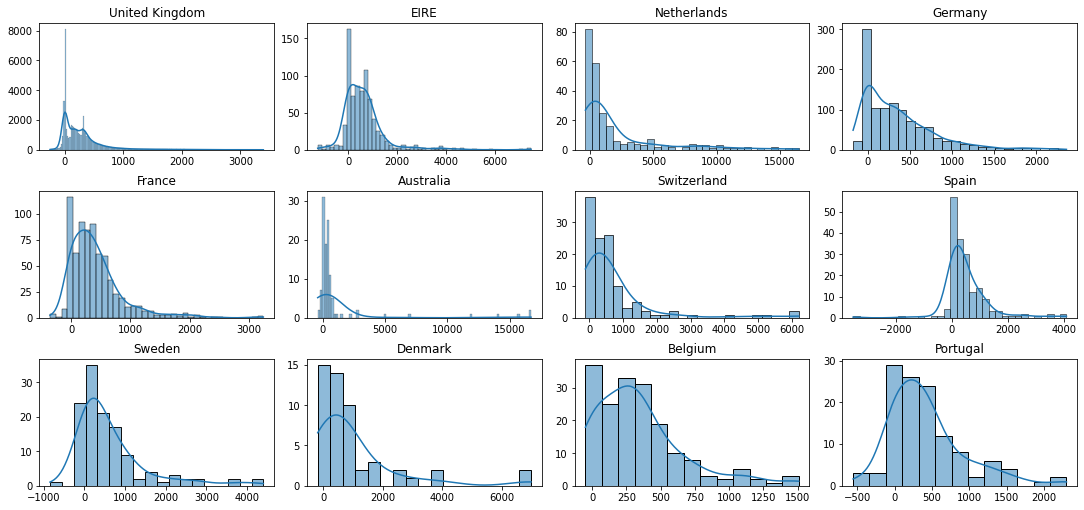

In [30]:
qa.seaborn_histplot_grid(retail_df, value_colname='order_value', groupby_colname='country', groupby_categories=top_selling_countries)

# Data cleaning
<a id='h1_data_cleaning'></a>

## Remove invoices with value £0.00

In [31]:
len(retail_df.loc[retail_df['order_value'] == 0])

5254

In [32]:
len(retail_df)

53002

In [33]:
retail_df = retail_df.loc[retail_df['order_value'] != 0]

In [34]:
len(retail_df)

47748

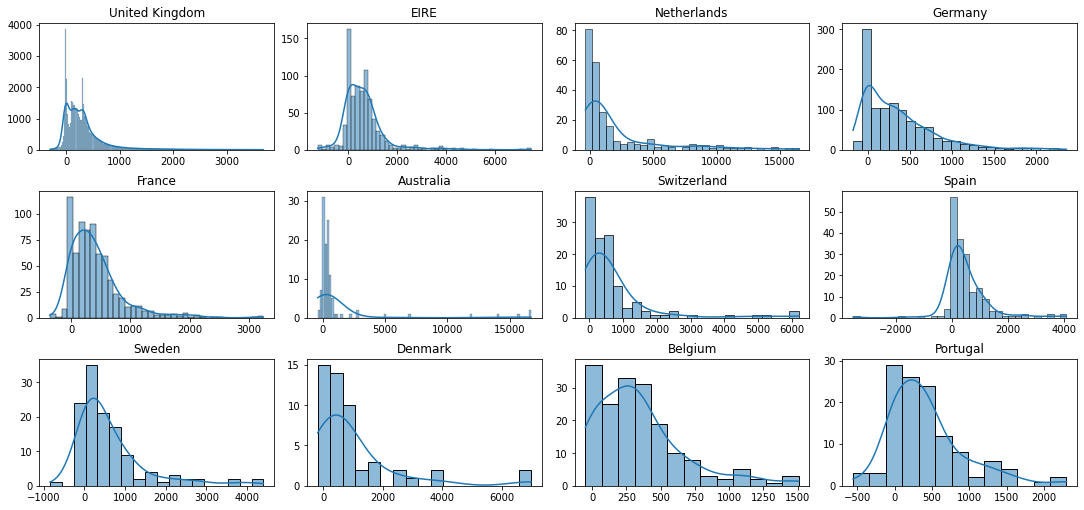

In [35]:
qa.seaborn_histplot_grid(retail_df, value_colname='order_value', groupby_colname='country', groupby_categories=top_selling_countries)

# Create a basic sales report
<a id='h1_basic_sales_report'></a>

<font style="font-size:20px">Goal</font> \
Compare the total sales in period __Q1_2010__ with the total sales in period __Q1_2011__, country by country.

The output should be a dataframe with `country` as the index, and the following columns:
* The number of orders in {Q1_2010, Q1_2011}.
* The total sales in {Q1_2010, Q1_2011}.
* The change in sales (increase or decrease) in £ from Q1_2010 to Q1_2011.
* The relative change in sales, expressed as a fraction. E.g. 0.25 means a 25% increase in sales; -0.05 means a 5% decrease.

In [36]:
period_id_0, period_id_1 = 'Q1_2010', 'Q1_2011'

## Create a custom aggregate function for use with `apply`

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.apply.html

### Example function

In [37]:
def example_apply_fn(df: pd.DataFrame) -> pd.Series:
    '''Simple example function for use as follows: `pd.DataFrame.groupby(...).apply(example_apply_fn)`.
    To be compatible with `apply()`, a function must take a pandas DataFrame as its first argument and return a DataFrame, Series or scalar.'''
    return pd.Series(
        {
            'sales':      df['order_value'].sum(),
            'n_invoices': len(df['order_value'])
        }
    )

In [38]:
retail_df.groupby([   # The `groupby` column(s) become the index of the output dataframe.
    'country'
]).apply(             # The function specified in `apply` is applied to each of the dataframes returned by `groupby`.
    example_apply_fn  # The outputs of this function are stitched together to form the output dataframe.
)

,sales,n_invoices
country,,
Australia,1.671291e+05,117.0
Belgium,6.357449e+04,183.0
Denmark,6.574109e+04,53.0
EIRE,6.155196e+05,808.0
France,3.281918e+05,747.0
Germany,4.179886e+05,1097.0
Netherlands,5.485249e+05,249.0
Portugal,5.313680e+04,124.0
Spain,9.185948e+04,188.0


### Write a `compare_sales()` function

Now we will write a new function for use with `apply`. The function must create an output dataframe as specified in the Goal.

A reminder of the required columns:
* The number of orders in {Q1_2010, Q1_2011}.
* The total sales in {Q1_2010, Q1_2011}.
* The change in sales (increase or decrease) in £ from Q1_2010 to Q1_2011.
* The relative change in sales, expressed as a fraction. E.g. 0.25 means a 25% increase in sales; -0.05 means a 5% decrease.

Let's also allow the names of the two periods being compared to be passed as arguments.

In [39]:
def compare_sales(df: pd.DataFrame, period_id_0: str, period_id_1: str) -> pd.Series:
    '''Usage: `retail_df.groupby('country').apply(compare_sales, period_id_0, period_id_1)`.
    
    Args:
        period_id_0 (str): Name of the first period to compare--matching one of the periods from the `period_id` column of `retail_df`. E.g. 'Q1_2011'.
        period_id_1 (str): Name of the second period to compare. E.g. 'Q1_2010'.
    '''
    df_p0 = df.loc[df['period_id'] == period_id_0]
    df_p1 = df.loc[df['period_id'] == period_id_1]
    
    return pd.Series(
        {
            f'n_orders_{period_id_0}':  len(df_p0),
            f'n_orders_{period_id_1}':  len(df_p1),
            f'sales_{period_id_0}':     ...,
            f'sales_{period_id_1}':     ...,
            'Δ_sales':                  ... - ...,
            'rel_change_sales':         ... / ... - 1
        }
    )

In [40]:
def compare_sales(df: pd.DataFrame, period_id_0: str, period_id_1: str) -> pd.Series:
    '''Usage: `retail_df.groupby('country').apply(compare_sales, period_id_0, period_id_1)`.
    
    Args:
        period_id_0 (str): Name of the first period to compare--matching one of the periods from the `period_id` column of `retail_df`. E.g. 'Q1_2011'.
        period_id_1 (str): Name of the second period to compare. E.g. 'Q1_2010'.
    '''
    df_p0 = df.loc[df['period_id'] == period_id_0]
    df_p1 = df.loc[df['period_id'] == period_id_1]
    
    p0_sales_sum = df_p0['order_value'].sum()
    p1_sales_sum = df_p1['order_value'].sum()
    
    return pd.Series(
        {
            f'n_orders_{period_id_0}':  len(df_p0),
            f'n_orders_{period_id_1}':  len(df_p1),
            f'sales_{period_id_0}':     p0_sales_sum,
            f'sales_{period_id_1}':     p1_sales_sum,
            'Δ_sales':                  p1_sales_sum - p0_sales_sum,
            'rel_change_sales':         p1_sales_sum / p0_sales_sum - 1
        }
    )

### Test your function

In [41]:
# sales_by_country = retail_df.loc[
#     retail_df['period_id'].isin([period_id_0, period_id_1])

sales_by_country = retail_df.groupby([
    'country'
]).apply(                     # Note the syntax: arguments to our `compare_sales()` function must be passed as keyword arguments (`kwargs`) to `apply()`.
    compare_sales,
    period_id_0=period_id_0,
    period_id_1=period_id_1
).reindex(                    # An optional step: order the output dataframe by `top_selling_countries`.
    top_selling_countries
)

sales_by_country

,n_orders_Q1_2010,n_orders_Q1_2011,sales_Q1_2010,sales_Q1_2011,Δ_sales,rel_change_sales
country,,,,,,
United Kingdom,4464.0,3993.0,1612315.209,1402263.60,-210051.609,-0.130279
EIRE,107.0,52.0,102138.330,50113.89,-52024.440,-0.509353
Netherlands,35.0,20.0,69119.320,71959.76,2840.440,0.041095
Germany,123.0,113.0,37131.290,39590.69,2459.400,0.066235
France,54.0,95.0,25761.240,40458.88,14697.640,0.570533
Australia,5.0,19.0,1459.050,40700.47,39241.420,26.895185
Switzerland,4.0,12.0,1429.300,8744.13,7314.830,5.117771
Spain,27.0,25.0,4872.860,14598.89,9726.030,1.995959
Sweden,19.0,8.0,11476.910,8496.40,-2980.510,-0.259696


## Improve the readability of the sales dataframe
The function `sales_dataframe_styler()` is provided to improve the readability of the sales summary dataframes generated during this lesson.

In [42]:
qa.sales_dataframe_styler(sales_by_country, period_id_0, period_id_1)

,n_orders_Q1_2010,n_orders_Q1_2011,sales_Q1_2010,sales_Q1_2011,Δ_sales,rel_change_sales
country,,,,,,
United Kingdom,"4,464","3,993","£1,612,315.21","£1,402,263.60","£-210,051.61",-13.03%
EIRE,107,52,"£102,138.33","£50,113.89","£-52,024.44",-50.94%
Netherlands,35,20,"£69,119.32","£71,959.76","£+2,840.44",+4.11%
Germany,123,113,"£37,131.29","£39,590.69","£+2,459.40",+6.62%
France,54,95,"£25,761.24","£40,458.88","£+14,697.64",+57.05%
Australia,5,19,"£1,459.05","£40,700.47","£+39,241.42","+2,689.52%"
Switzerland,4,12,"£1,429.30","£8,744.13","£+7,314.83",+511.78%
Spain,27,25,"£4,872.86","£14,598.89","£+9,726.03",+199.60%
Sweden,19,8,"£11,476.91","£8,496.40","£-2,980.51",-25.97%


Our basic sales report is now complete.

Questions:
* Does this table tell the whole story?
* What important information is missing (if any)?
* How can we improve this sales report?

# Create a better sales report
<a id='h1_better_sales_report'></a>

> “It is easy to lie with statistics. It is hard to tell the truth without statistics.”
>
> — Andrejs Dunkels

The basic sales report dataframe provides some standard metrics of sales performance. However, these figures lack any measure of statistical significance.

It would be much better if the sales report gave us a __confidence interval__ around each of the figures of interest. These confidence intervals can be estimated via __bootstrapping__.

## Bootstrapping: a quick reminder
Bootstrapping is a method of sampling with replacement from a data set in order to generate a new, unbiased sample from approximately the same distribution that generated the original data.

In [47]:
for i in range(3):
    print(np.random.choice(range(10), size=10, replace=True))

[6 0 1 8 5 9 5 0 9 5]
[2 6 1 7 2 3 7 0 5 8]
[3 7 6 3 4 3 5 3 6 4]


In [48]:
def compare_sales_bootstrapped(df: pd.DataFrame, period_id_0: str, period_id_1: str, n_boot: int=5000) -> pd.Series:
    '''An upgraded version of `compare_sales` which adds bootstrapped sales metrics. Bootstrapped columns have the prefix "bs_".'''
    df_p0 = df.loc[df['period_id'] == period_id_0]
    df_p1 = df.loc[df['period_id'] == period_id_1]
    
    p1_minus_p0 = []
    p1_div_p0 = []
    
    # Bootstrap loop.
    for i in range(n_boot):
        # Draw a bootstrap sample of order value for Period 0 and take the sum. Do the same for Period 1.
        bs_p0_sales = np.sum(np.random.choice(df_p0['order_value'], size=len(df_p0), replace=True))
        bs_p1_sales = np.sum(np.random.choice(df_p1['order_value'], size=len(df_p1), replace=True))
        
        # Append the difference of the bootstrapped sales values to list `p1_minus_p0`, and their quotient to `p1_div_p0`.
        p1_minus_p0.append(bs_p1_sales - bs_p0_sales)
        p1_div_p0.append(bs_p1_sales / bs_p0_sales)
    
    # Compute the unbootstrapped (i.e. actual) sales for each Period.
    p0_sales = df_p0['order_value'].sum()
    p1_sales = df_p1['order_value'].sum()
    
    # Compute the percentiles for the bootstrapped £ change and relative change in sales between Period 0 and Period 1.
    Δ_percentiles = np.quantile(p1_minus_p0, [0.025, 0.5, 0.975])
    rel_change_percentiles = np.quantile(p1_div_p0, [0.025, 0.5, 0.975])

    return pd.Series(
        {
            f'n_orders_{period_id_0}':     len(df_p0),                       # Number of orders for Period 0.
            f'n_orders_{period_id_1}':     len(df_p1),                       # Number of orders for Period 1.
            f'sales_{period_id_0}':        p0_sales,                         # Unbootstrapped (i.e. actual) sales for Period 0.
            f'sales_{period_id_1}':        p1_sales,                         # Unbootstrapped (i.e. actual) sales for Period 1.
            'Δ_sales':                     p1_sales - p0_sales,              # £ difference/change in sales between Period 0 and Period 1.
            'rel_change_sales':            p1_sales / p0_sales - 1,          # Relative change in sales between Period 0 and Period 1. E.g. 0.25 means a +25% change.
            'bs_Δ_sales_mean':             np.nanmean(p1_minus_p0),          # Mean of bootstraps of £ change in sales between Period 0 and Period 1.
            'bs_Δ_sales_sd':               np.nanstd(p1_minus_p0),           # Standard deviation of bootstraps of £ change in sales between Period 0 and Period 1.
            'bs_Δ_sales_q0.025':           Δ_percentiles[0],                 # 2.5th percentile of bootstraps of £ change in sales between Period 0 and Period 1.
            'bs_Δ_sales_q0.5':             Δ_percentiles[1],                 # 50th percentile (i.e. median) of bootstraps of £ change in sales between Period 0 and Period 1.
            'bs_Δ_sales_q0.975':           Δ_percentiles[2],                 # 97.5th percentile of bootstraps of £ change in sales between Period 0 and Period 1.
            'bs_rel_change_sales_mean':    np.nanmean(p1_div_p0),            # Mean of bootstraps of relative change in sales between Period 0 and Period 1.
            'bs_rel_change_sales_sd':      np.nanstd(p1_div_p0),             # Standard deviation of bootstraps of relative change in sales between Period 0 and Period 1.
            'bs_rel_change_sales_q0.025':  rel_change_percentiles[0] - 1,    # 2.5th percentile of bootstraps of relative change in sales between Period 0 and Period 1.
            'bs_rel_change_sales_q0.5':    rel_change_percentiles[1] - 1,    # 50th percentile of bootstraps of relative change in sales between Period 0 and Period 1.
            'bs_rel_change_sales_q0.975':  rel_change_percentiles[2] - 1,    # 97.5th percentile of bootstraps of relative change in sales between Period 0 and Period 1.
            f'{period_id_1}_>_{period_id_0}_frac': np.mean(                  # The fraction of bootstraps in which the sales in Period 1 exceeded those in Period 0.
                [quotient >= 1 for quotient in p1_div_p0]
            )
        }
    )

In [49]:
%%time
# ~ 16 s for n_boot == 20,000.
bs_sales_by_country = retail_df.groupby(
    ['country']
).apply(
    compare_sales_bootstrapped,
    period_id_0=period_id_0,
    period_id_1=period_id_1,
    n_boot=20000
).reindex(
    top_selling_countries
)

Wall time: 16.5 s


In [50]:
qa.sales_dataframe_styler(bs_sales_by_country, period_id_0, period_id_1)

,n_orders_Q1_2010,n_orders_Q1_2011,sales_Q1_2010,sales_Q1_2011,Δ_sales,rel_change_sales,bs_Δ_sales_mean,bs_Δ_sales_sd,bs_Δ_sales_q0.025,bs_Δ_sales_q0.5,bs_Δ_sales_q0.975,bs_rel_change_sales_mean,bs_rel_change_sales_sd,bs_rel_change_sales_q0.025,bs_rel_change_sales_q0.5,bs_rel_change_sales_q0.975,Q1_2011_>_Q1_2010_frac
country,,,,,,,,,,,,,,,,,
United Kingdom,"4,464","3,993","£1,612,315.21","£1,402,263.60","£-210,051.61",-13.03%,"£-209,368.72","£+133,978.91","£-477,954.02","£-207,888.93","£+52,907.83",+87.12%,+8.14%,-28.97%,-12.89%,+3.34%,0.058150
EIRE,107,52,"£102,138.33","£50,113.89","£-52,024.44",-50.94%,"£-52,580.16","£+48,625.09","£-161,143.74","£-47,667.45","£+26,406.94",+59.28%,+36.08%,-83.43%,-50.01%,+54.48%,0.123550
Netherlands,35,20,"£69,119.32","£71,959.76","£+2,840.44",+4.11%,"£+2,185.22","£+30,242.05","£-58,727.41","£+2,591.66","£+59,825.48",+115.40%,+56.09%,-58.00%,+3.94%,+157.94%,0.538250
Germany,123,113,"£37,131.29","£39,590.69","£+2,459.40",+6.62%,"£+2,472.24","£+7,312.30","£-12,041.40","£+2,536.51","£+16,472.78",+109.14%,+21.42%,-26.39%,+6.81%,+57.33%,0.634500
France,54,95,"£25,761.24","£40,458.88","£+14,697.64",+57.05%,"£+14,653.93","£+6,466.88","£+2,308.52","£+14,562.45","£+27,623.02",+160.28%,+32.02%,+7.48%,+57.01%,+132.21%,0.991100
Australia,5,19,"£1,459.05","£40,700.47","£+39,241.42","+2,689.52%","£+39,318.29","£+21,046.56","£+2,258.40","£+37,398.96","£+85,602.53","+3,194.40%","+2,268.06%",+166.74%,"+2,611.81%","+8,791.24%",0.999400
Switzerland,4,12,"£1,429.30","£8,744.13","£+7,314.83",+511.78%,"£+7,292.91","£+2,612.62","£+2,999.60","£+7,043.50","£+13,030.19",+616.98%,+195.21%,+202.84%,+495.28%,+956.57%,1.000000
Spain,27,25,"£4,872.86","£14,598.89","£+9,726.03",+199.60%,"£+9,714.32","£+5,141.23",£-260.06,"£+9,697.36","£+19,947.76",+498.40%,"+9,568.49%",-13.52%,+197.10%,"+1,200.72%",0.965250
Sweden,19,8,"£11,476.91","£8,496.40","£-2,980.51",-25.97%,"£-3,054.16","£+5,162.20","£-12,491.23","£-3,286.03","£+7,507.94",+78.11%,+47.46%,-91.23%,-28.86%,+88.31%,0.271800


In [51]:
qa.sales_dataframe_styler(
    bs_sales_by_country[[colname for colname in bs_sales_by_country.columns if ('Δ' in colname) or ('n_orders' in colname)] + [bs_sales_by_country.columns[-1]]],
    period_id_0,
    period_id_1
)

,n_orders_Q1_2010,n_orders_Q1_2011,Δ_sales,bs_Δ_sales_mean,bs_Δ_sales_sd,bs_Δ_sales_q0.025,bs_Δ_sales_q0.5,bs_Δ_sales_q0.975,Q1_2011_>_Q1_2010_frac
country,,,,,,,,,
United Kingdom,"4,464","3,993","£-210,051.61","£-209,368.72","£+133,978.91","£-477,954.02","£-207,888.93","£+52,907.83",0.058150
EIRE,107,52,"£-52,024.44","£-52,580.16","£+48,625.09","£-161,143.74","£-47,667.45","£+26,406.94",0.123550
Netherlands,35,20,"£+2,840.44","£+2,185.22","£+30,242.05","£-58,727.41","£+2,591.66","£+59,825.48",0.538250
Germany,123,113,"£+2,459.40","£+2,472.24","£+7,312.30","£-12,041.40","£+2,536.51","£+16,472.78",0.634500
France,54,95,"£+14,697.64","£+14,653.93","£+6,466.88","£+2,308.52","£+14,562.45","£+27,623.02",0.991100
Australia,5,19,"£+39,241.42","£+39,318.29","£+21,046.56","£+2,258.40","£+37,398.96","£+85,602.53",0.999400
Switzerland,4,12,"£+7,314.83","£+7,292.91","£+2,612.62","£+2,999.60","£+7,043.50","£+13,030.19",1.000000
Spain,27,25,"£+9,726.03","£+9,714.32","£+5,141.23",£-260.06,"£+9,697.36","£+19,947.76",0.965250
Sweden,19,8,"£-2,980.51","£-3,054.16","£+5,162.20","£-12,491.23","£-3,286.03","£+7,507.94",0.271800


In [52]:
qa.sales_dataframe_styler(
    bs_sales_by_country[[colname for colname in bs_sales_by_country.columns if ('rel_change' in colname) or ('n_orders' in colname)] + [bs_sales_by_country.columns[-1]]].drop(columns=['bs_rel_change_sales_mean', 'bs_rel_change_sales_sd']),
    period_id_0,
    period_id_1
)

,n_orders_Q1_2010,n_orders_Q1_2011,rel_change_sales,bs_rel_change_sales_q0.025,bs_rel_change_sales_q0.5,bs_rel_change_sales_q0.975,Q1_2011_>_Q1_2010_frac
country,,,,,,,
United Kingdom,"4,464","3,993",-13.03%,-28.97%,-12.89%,+3.34%,0.058150
EIRE,107,52,-50.94%,-83.43%,-50.01%,+54.48%,0.123550
Netherlands,35,20,+4.11%,-58.00%,+3.94%,+157.94%,0.538250
Germany,123,113,+6.62%,-26.39%,+6.81%,+57.33%,0.634500
France,54,95,+57.05%,+7.48%,+57.01%,+132.21%,0.991100
Australia,5,19,"+2,689.52%",+166.74%,"+2,611.81%","+8,791.24%",0.999400
Switzerland,4,12,+511.78%,+202.84%,+495.28%,+956.57%,1.000000
Spain,27,25,+199.60%,-13.52%,+197.10%,"+1,200.72%",0.965250
Sweden,19,8,-25.97%,-91.23%,-28.86%,+88.31%,0.271800
